<a href="https://colab.research.google.com/github/Nitinyad/LLM-from-scratch/blob/main/utl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## step1 : Creating tokens

In [1]:
from importlib.metadata import version

print("torch version : " , version("torch"))
print("tiktoken version : " , version("tiktoken"))

torch version :  2.6.0+cu124
tiktoken version :  0.9.0


this chapter cover data preparation and sampling to get input data "ready" for the LLM.

In [2]:
import os
import urllib.request


if not os.path.exists("sample_data/the-verdict.txt"):
  url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
  file_path = "the-verdict.txt"
  urllib.request.urlretrieve(url, file_path)

# Tokenizing the text

breaks the word into the small units

In [3]:
with open("sample_data/the-verdict.txt" , "r" , encoding = "utf-8") as f:
  raw_text = f.read()

print("the length of the characters : " , len(raw_text))
print(raw_text[:100])

the length of the characters :  20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


- the goal is to tokenize and embed this text to LLM
- develop a simple tokenizer based on some simple text that we can apply later to the text above
- we will use the regular expression (re) for the splitting the text based on whitespaces.


In [4]:
import re

text = "Hello, world. This, is a test."

result = re.split(r'(\s)' , text )

print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


In [5]:
result = re.split(r'([,.]|\s)' , text)
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


In [6]:
 ## strip whitespaces and filter out the white spaces
 result = [item for item in result if item.strip()]
 print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


In [7]:
text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;!?_"()\']|--|\s)' , text )
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [8]:
preprocessed = re.split(r'([,.:;\'!_()?]|--|\s)' , raw_text)
preprocessed = [item for item in preprocessed if item.strip()]
print(preprocessed[:10])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius']


In [9]:
print(len(preprocessed))

4606


Converting the token into tokenID

In [10]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)

1158


In [11]:
vocab = {token : integer for integer , token in enumerate(all_words)}
print(vocab)

{'!': 0, '"': 1, '"Ah': 2, '"Be': 3, '"Begin': 4, '"By': 5, '"Come': 6, '"Destroyed': 7, '"Don': 8, '"Gisburns"': 9, '"Grindles': 10, '"Hang': 11, '"Has': 12, '"How': 13, '"I': 14, '"If': 15, '"It': 16, '"Jack': 17, '"Money': 18, '"Moon-dancers"': 19, '"Mr': 20, '"Mrs': 21, '"My': 22, '"Never': 23, '"Of': 24, '"Oh': 25, '"Once': 26, '"Only': 27, '"Or': 28, '"That': 29, '"The': 30, '"Then': 31, '"There': 32, '"This': 33, '"We': 34, '"Well': 35, '"What': 36, '"When': 37, '"Why': 38, '"Yes': 39, '"You': 40, '"but': 41, '"deadening': 42, '"dragged': 43, '"effects"': 44, '"interesting"': 45, '"lift': 46, '"obituary"': 47, '"strongest': 48, '"strongly"': 49, '"sweetly"': 50, "'": 51, '(': 52, ')': 53, ',': 54, '--': 55, '.': 56, ':': 57, ';': 58, '?': 59, 'A': 60, 'Among': 61, 'And': 62, 'Are': 63, 'Arrt': 64, 'As': 65, 'At': 66, 'Burlington': 67, 'But': 68, 'By': 69, 'Carlo': 70, 'Chicago': 71, 'Claude': 72, 'Croft': 73, 'Devonshire': 74, 'Don': 75, 'Dubarry': 76, 'Emperors': 77, 'Florence'

In [12]:
for i ,item in enumerate(vocab.items()):
  print(item)
  if i >= 50:
    break

('!', 0)
('"', 1)
('"Ah', 2)
('"Be', 3)
('"Begin', 4)
('"By', 5)
('"Come', 6)
('"Destroyed', 7)
('"Don', 8)
('"Gisburns"', 9)
('"Grindles', 10)
('"Hang', 11)
('"Has', 12)
('"How', 13)
('"I', 14)
('"If', 15)
('"It', 16)
('"Jack', 17)
('"Money', 18)
('"Moon-dancers"', 19)
('"Mr', 20)
('"Mrs', 21)
('"My', 22)
('"Never', 23)
('"Of', 24)
('"Oh', 25)
('"Once', 26)
('"Only', 27)
('"Or', 28)
('"That', 29)
('"The', 30)
('"Then', 31)
('"There', 32)
('"This', 33)
('"We', 34)
('"Well', 35)
('"What', 36)
('"When', 37)
('"Why', 38)
('"Yes', 39)
('"You', 40)
('"but', 41)
('"deadening', 42)
('"dragged', 43)
('"effects"', 44)
('"interesting"', 45)
('"lift', 46)
('"obituary"', 47)
('"strongest', 48)
('"strongly"', 49)
('"sweetly"', 50)


In [13]:
## encoder function turns text into tokenid
## decoder function turns tokenid into text again

class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)

        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text




In [14]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know,"
           Mrs. Gisburn said with pardonable pride."""

ids = tokenizer.encode(text)
print(ids)

[1, 95, 51, 880, 1015, 633, 564, 776, 54, 1154, 627, 54, 1, 104, 56, 82, 881, 1136, 784, 823, 56]


In [15]:
tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

In [16]:
tokenizer.decode(tokenizer.encode(text))

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

## adding special context token

it is useful to add some "special" token for unknown words and to denote the end of the text

some tokenizer uses the special tokens to help the llm to understand the additional context (or if new word comes)

like GPT-2 only use the |endoftext| --> to mark where the text end (this is usefull when we uploaded the multiple file and we have to differenct between them)

In [17]:
tokenizer = SimpleTokenizerV1(vocab)

text = "Hello, do you like tea. Is this-- a test?"
tokens = tokenizer.encode(text)
print(tokens)

KeyError: 'Hello'

the above error came because 'hello' work is not in the vocalbary we have made

In [22]:
all_tokens = sorted(set(preprocessed))

all_tokens.extend(['<|endoftext|>' , '<|unk|>'])

vocab = {token: integer for integer , token  in enumerate(all_tokens)}

print(vocab)

for i , item in enumerate(list(vocab.items())[-5:]):
  print(item)


{'!': 0, '"': 1, '"Ah': 2, '"Be': 3, '"Begin': 4, '"By': 5, '"Come': 6, '"Destroyed': 7, '"Don': 8, '"Gisburns"': 9, '"Grindles': 10, '"Hang': 11, '"Has': 12, '"How': 13, '"I': 14, '"If': 15, '"It': 16, '"Jack': 17, '"Money': 18, '"Moon-dancers"': 19, '"Mr': 20, '"Mrs': 21, '"My': 22, '"Never': 23, '"Of': 24, '"Oh': 25, '"Once': 26, '"Only': 27, '"Or': 28, '"That': 29, '"The': 30, '"Then': 31, '"There': 32, '"This': 33, '"We': 34, '"Well': 35, '"What': 36, '"When': 37, '"Why': 38, '"Yes': 39, '"You': 40, '"but': 41, '"deadening': 42, '"dragged': 43, '"effects"': 44, '"interesting"': 45, '"lift': 46, '"obituary"': 47, '"strongest': 48, '"strongly"': 49, '"sweetly"': 50, "'": 51, '(': 52, ')': 53, ',': 54, '--': 55, '.': 56, ':': 57, ';': 58, '?': 59, 'A': 60, 'Among': 61, 'And': 62, 'Are': 63, 'Arrt': 64, 'As': 65, 'At': 66, 'Burlington': 67, 'But': 68, 'By': 69, 'Carlo': 70, 'Chicago': 71, 'Claude': 72, 'Croft': 73, 'Devonshire': 74, 'Don': 75, 'Dubarry': 76, 'Emperors': 77, 'Florence'

In [23]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text


In [24]:
tokenizer = SimpleTokenizerV2(vocab)


text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))
print(text)
ids = tokenizer.encode(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [25]:
tokenizer.decode(ids)

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

## BytePair encoding(BPE)


- gpt-2 used Bytepair encoding as a tokenizer
- it allows the model to break down the words that aren't in the predefined vocabulary into smaller subwords units or even individual characters
- for example , gpt-2's vocabulary doesnt have the "unfamiliarword" , it might tokens into the ['un' , 'famil' , 'iar' , 'word']


In [26]:
!pip install tiktoken

In [27]:
import tiktoken
from importlib.metadata import version

print(version('tiktoken'))

0.9.0


In [28]:
tokenizer = tiktoken.get_encoding('gpt2')

In [29]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text , allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [30]:
text = tokenizer.decode(integers)
print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


BPE tokenizer breaks down the unknown words into subwords and individual characters

## data sampling with sliding window


we train LLMs to generate one word at a time , so we want to prepare the training data accordingly , where the next word in a sequence represents the target the predict :  

In [31]:
with open('sample_data/the-verdict.txt' , 'r' , encoding = 'utf-8') as f:
  text = f.read()

enc_text = tokenizer.encode(text)

print(len(enc_text))

5145


In [32]:
enc_sample = enc_text[50:]

In [33]:
context_size = 4

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x:{x}")
print(f"y:     {y}")

x:[290, 4920, 2241, 287]
y:     [4920, 2241, 287, 257]


one by one prediction will look like this:

In [34]:
for i in range(1,context_size + 1):
  context = enc_sample[:i]
  predict = enc_sample[i]
  print(f"{context} --> {predict}")

[290] --> 4920
[290, 4920] --> 2241
[290, 4920, 2241] --> 287
[290, 4920, 2241, 287] --> 257


In [35]:
for i in range(1 , context_size + 1):
  context = enc_sample[:i]
  predict = enc_sample[i]
  print(tokenizer.decode(context) , " -->" , tokenizer.decode([predict]))

 and  -->  established
 and established  -->  himself
 and established himself  -->  in
 and established himself in  -->  a


Now , we implement a simple **data loader** that iterates over the input dataset and `returns` inputs and targets shifted by one.

In [36]:
import torch
print("pytorch version : " , torch.__version__)

pytorch version :  2.6.0+cu124


we will use the sliding window approach , changing the position by + 1

create a dataset and data loader that extract the chunks from the input text dataset

In [37]:
from torch.utils.data import Dataset , DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self , txt , tokenizer , max_length , stride):
    self.input_ids = []
    self.target_ids = []

    #tokenize the entire text
    token_ids = tokenizer.encode(txt , allowed_special = {"<|endoftext|>"})
    assert len(token_ids) > max_length, "Number of tokenized input must be equal to max_length + 1"

    #use the sliding window to chunk the book into the overlapping sequence of max_length
    for i in range(0 , len(token_ids) - max_length , stride):
      input_chunk = token_ids[i:i+max_length]
      target_chunk = token_ids[i+1 : i + max_length + 1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)
  def __getitem__(self , idx):
    return self.input_ids[idx] , self.target_ids[idx]


In [38]:
def create_dataloader_v1(txt , batch_size = 4 , max_length = 256 , stride = 128 , shuffle = True ,
                         drop_last = True , num_workers = 0):
  tokenizer = tiktoken.get_encoding('gpt2')

  dataset = GPTDatasetV1(txt , tokenizer , max_length , stride)

  dataloader = DataLoader(
      dataset ,
      batch_size = batch_size ,
      shuffle = shuffle ,
      drop_last = drop_last ,
      num_workers = num_workers
  )

  return dataloader


In [39]:
with open("sample_data/the-verdict.txt" , "r" , encoding ="utf-8") as f:
  raw_text = f.read()


In [40]:
dataloader = create_dataloader_v1(raw_text , batch_size = 1 , max_length = 4 , stride = 1 , shuffle=False)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [41]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


if we increased stride here so that we don't have overlaps between the batches , since more overlap could increase the overfitting


In [42]:
dataloader = create_dataloader_v1(raw_text , batch_size = 8 , max_length = 4 , stride = 4 , shuffle= False)


data_iter = iter(dataloader)
input , target = next(data_iter)
print("input : " , input)
print("target : " , target)

input :  tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
target :  tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


## creating a token embedding

- the data is almost ready for llm
- but lastly we have to embedd the tokens to continuous vector representation using embedding layer
- and usually these embedding layers are part of llm , are updated (training) during the modal training.

In [43]:
input_ids = torch.tensor([2,3,5,1])

for the sake of simplicity , suppose we have a small vocabulary of only 6 words and we want to create embedding of size 3

In [44]:
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size , output_dim)

In [45]:
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


after we instantiated the embedding layer , let's now apply the it to a tokenID to obtain the vector embeddings

In [49]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


In [50]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


now the tokenids are converted into the `embedding vectors`

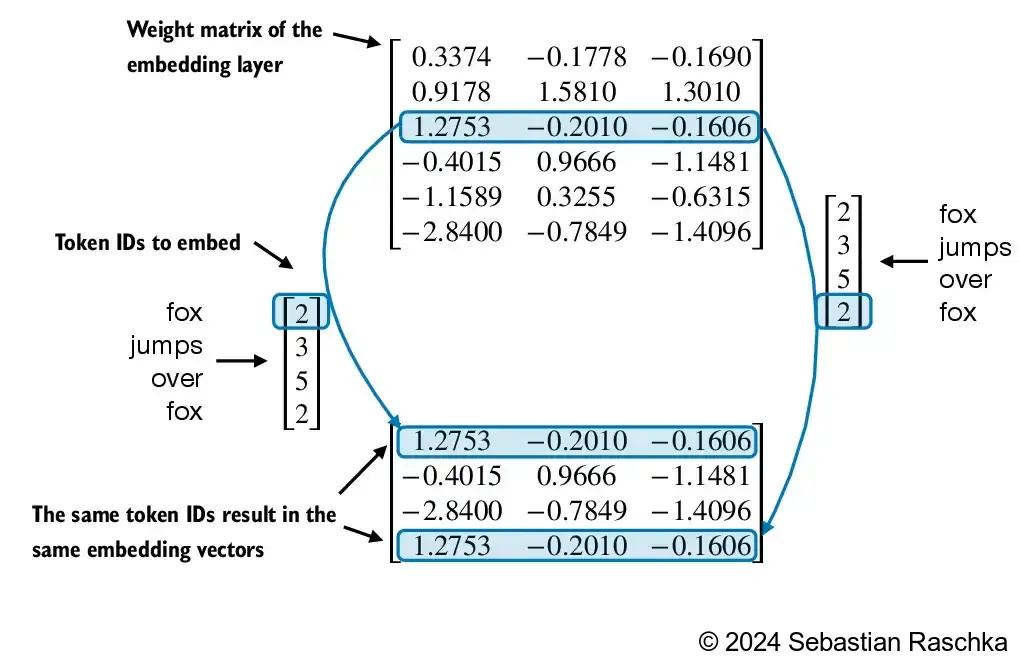

initialily these embedding vectors are `initialize randomly` , but during the training process the weights are `optimized`;

the embedding layer is `look-up operation` that retrive the rows from embedding layer weight matrix using token ids

## postional embedding (encoding the word position)

positional embedding is combined with the token embedding vector to form the input embedding for the llm

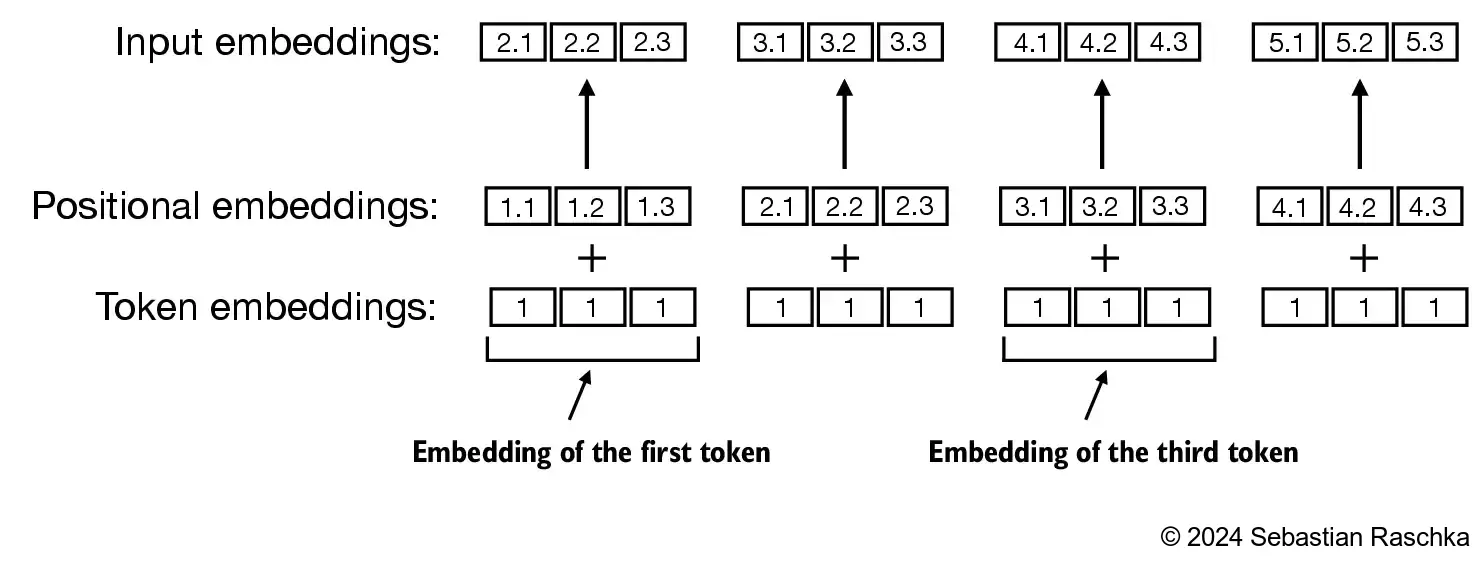

- the bytepair encoder has a vocabulary size of 50,257
- suppose we want to encode the input tokens into 256 dimensional vector representation.

In [60]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size , output_dim)

using the above token_embedding_layer , if we sample data from the `dataloader` , we embedd each token in each batch into a `256-dimensional vector representation` ,
the batch size of 8 with four token each , then result will end up `8 X 4 X 256 tensor`

data sampling with the sliding window,

In [54]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text , batch_size = 8 , max_length = max_length,
    stride = max_length , shuffle=False
)
data_iter = iter(dataloader)
inputs , targets = next(data_iter)


In [55]:
print("token ids : " , inputs)
print("targets vectors : " , targets)

token ids :  tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
targets vectors :  tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


In [57]:
print("input shapes  : " , inputs.shape)

input shapes  :  torch.Size([8, 4])


now we want to convert each of tokenid into 256-dimensional vector
steps :


```
[   40,   367,  2885,  1464],
[ 1807,  3619,   402,   271],
[10899,  2138,   257,  7026],
[15632,   438,  2016,   257],
[  922,  5891,  1576,   438],
[  568,   340,   373,   645],
[ 1049,  5975,   284,   502],
[  284,  3285,   326,    11]
```
now take the each input id like 40 --> then go to the look up table (embedding layer) and get the crossponding vector for that input id (of 256 -dimension)


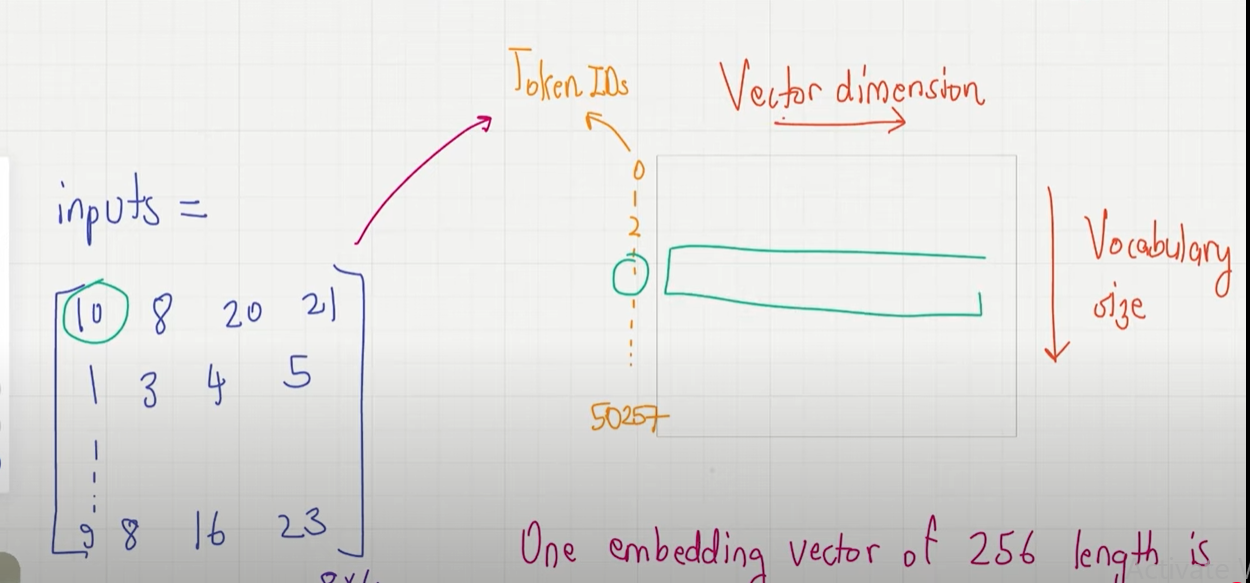

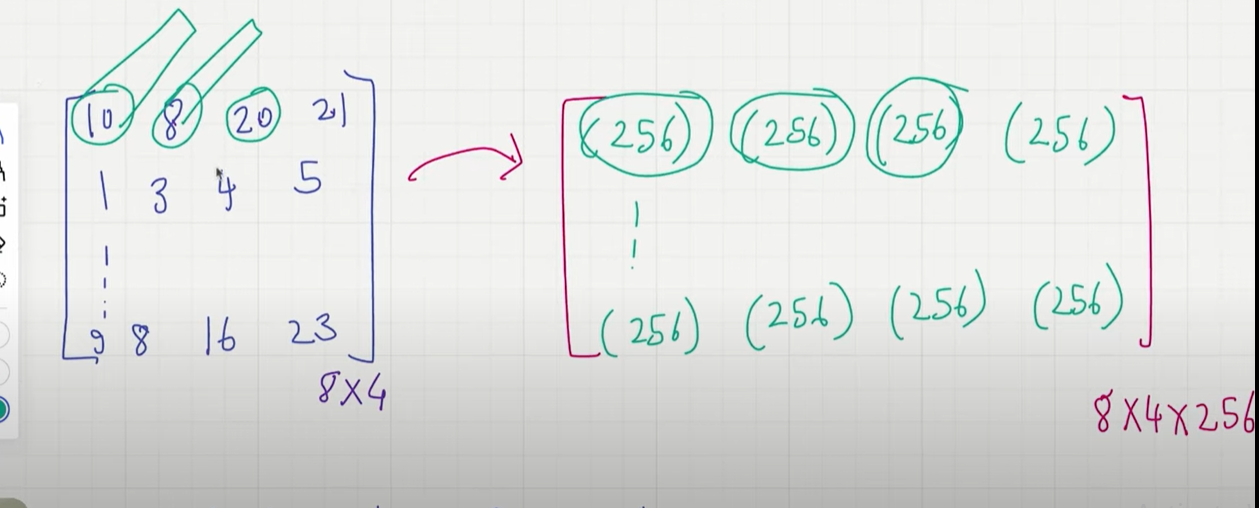

now we use the embedding layer to embedd these token ids into 256 - dimensions

In [63]:
token_embedding = token_embedding_layer(inputs)

print(token_embedding.shape)
## 8 (batch_size) , 4 (context_size) , 256(dimensions)

torch.Size([8, 4, 256])


now we will add positional embedding on top of these token embeddings for one batch and that will be the input to the llm

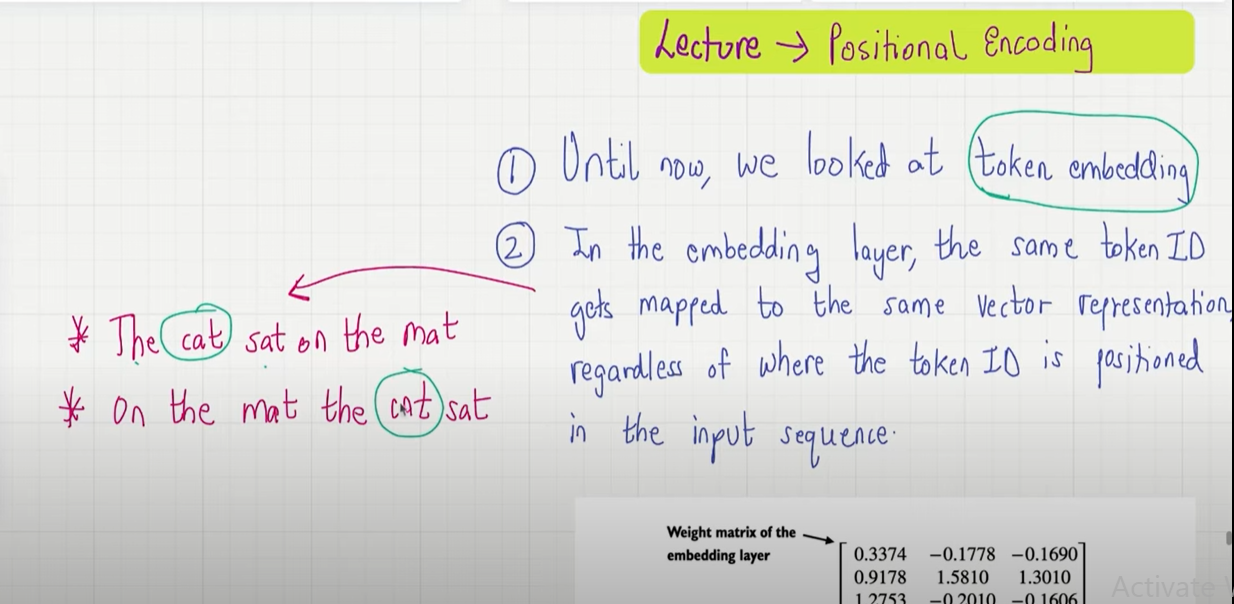

![Vizuara - Lecture 12 The entire Data Preprocessing Pipeline of Large Language Models (LLMs) [mk-6cFebjis - 893x543 - 1h27m12s].png](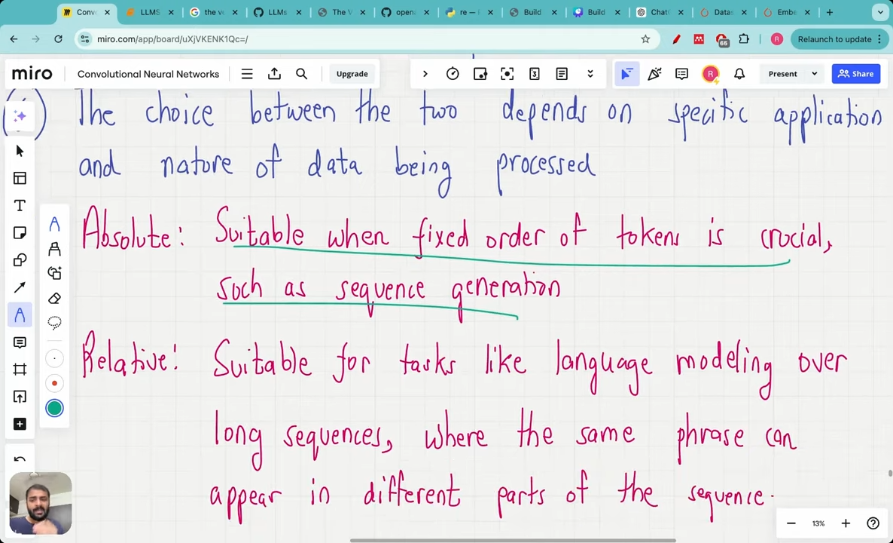)

In [64]:
context_length = max_length

pos_embedding_layer = torch.nn.Embedding(context_length , output_dim)

In [65]:
pos_embeddings = pos_embedding_layer(torch.arange(context_length))

print(pos_embeddings.shape)

torch.Size([4, 256])


to create the input for the llm , we simple add the token and positional embedding

In [67]:
input_embeddings = token_embedding + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])
